# <b> Assuming fixed the mass density produced by the ablation, repeat the analysis. </b>

### Check table in reference: "Turbulence_reverse_shock_2016_2017.ppt"

# General Analysis - Magnetic Rayleigh-Taylor Instability

### Toward a full analysis of MRT instability (This includes Hall Effects) - Simple Plasma class for caclualting the relevant parameters


'J.D. Huba, Rayleigh-Taylor Instability: Comparison of Hybrid and Nonideal MHD simulation, 1998'

'R. K. Bera, Yang Song, The effect of viscosity and resistivity on Rayleigh-Taylor instability induced mixing in magnetised HEDP, 2021'

'F.R.S. Taylor, The instability of liquid surfaces when accelerated in a direction perpendicular to their planes, 1949'

In [51]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cons
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex

from scipy.interpolate import CubicSpline

# Class: Plasma


In [52]:
class plasma:
    def __init__(self, A, density, Te, Ti, V, L, Atw, Zsrc, B):
        '''
        Args:
            example:
            ---------------------------------------------------------------------------------------
            al_flow = {'A':27, 'ne': 6.8e18, 'Te': Te, 'Ti': Ti, 'V':4e6, 'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
            al=Plasma(**al_flow)
            ---------------------------------------------------------------------------------------
            A:      ion mass in nucleon masses
            Te      electron temperature in eV
            V:      velocity in cm/s
            L:      length scale shock in cm.
            Atw:    Atwood Number
            Zsrc:   Charge State Model source, 'exp' or 'FLY'
            B:      Magnetic Field [Tesla]

        '''
        self.A              =   A                                                                          # Atomic mass weight
        self.density        =   density                                                                    # Density                                           [gr/cm^3]
        self.Te             =   Te                                                                         # Electron Temperature                              [eV]
        self.Ti             =   Ti                                                                         # Ion Temperature                                   [eV]
        self.V              =   V                                                                          # Bulk Velocity                                     [cm/s]
        self.L              =   L                                                                          # Maximum Radius of Expansion stagantion interface  [cm] 
        self.Atw            =   Atw                                                                        # Atwood Number
        self.Zsrc           =   Zsrc                                                                       # ZTe Tabled Source                                 [String]
        self.B              =   B                                                                          # Magnetic Field                                    [Tesla T]

        # Estimate Ionisation Charge State - Z - from Tabled Values
        Z_mod               =   self.ZTe()
        self.Z              =   Z_mod(self.Te)                                                             # Charge State for a given Te

        # Electron Density
        self.ne             =   (self.density * self.Z)/ (self.A * cons.m_p * 1e3)                         # Plasma Density                                     [cm^-3]

        # Ion density
        self.ni             =   self.ne/self.Z                                                             # Ion Density                                        [cm^-3]

        # Calculate Plasma Parameters
        self.params()
        # Calculate MRT Parameters
        self.MRTparams()

    def ZTe(self):
        """
          Function to return ZTe relation from ionisation state tables
        """
        A = self.A
        source = self.Zsrc
        # source = 'FLY'
        if A == 27:     # Aluminium
            if source == 'FLY':
                T_e, Z =  np.genfromtxt('./IonisationTables/Al_Z_1e18.txt', delimiter = '  ', usecols = [0,1], unpack = True)
            else:
                T_e, Z =  np.genfromtxt('./IonisationTables/zb_Al.dat', delimiter=' ', skip_header=2, usecols = [0,3], unpack = True)
        
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 64:     # Copper
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/Cu_Z_1e18.txt', delimiter='  ', usecols = [0,1], unpack = True)
            else:
                T_e, Z = np.genfromtxt('./IonisationTables/zb_Cu.dat', delimiter='     ', skip_header=2, usecols = [0,2], unpack = True)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 108:    # Silver
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/Ag_Z_1e18.txt', delimiter='  ', usecols = [0,1],unpack = True)
            else:
                print("No data available for A:",A)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 183:    # Tungsten
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/W_Z_1e18.txt', delimiter='  ', usecols = [0,1],unpack = True)
            else:
                T_e, Z = np.genfromtxt('./IonisationTables/zb_W.dat', delimiter=' ', usecols = [0,1],unpack = True)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 197:    # Gold
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/Au_Z_1e18.txt', delimiter='  ', usecols = [0,1],unpack = True)
            else:
                T_e, Z = np.genfromtxt('./IonisationTables/zb_Au.dat', delimiter=' ', usecols = [0,1],unpack = True)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        else:
            print("No data available for A:", A)

    def params(self):
        """
        Primary Plasma Parameters

        """
        # Scientific Constant
        m_e             =      cons.m_e                                                                 # Electron Mass          [Kg]
        m_i             =      self.A*cons.m_u                                                          # Ion Mass               [Kg]
        e               =      cons.e                                                                   # Elemental Charge       [C]
        mu_0            =      cons.mu_0                                                                # Vacuum Permeability    [N A^-2]
        epsilon_0       =      cons.epsilon_0                                                           # Vacuum Permittivity    [F m^-1]
        kb              =      cons.k                                                                   # Boltzmann Constant     [J K^-1]
        c               =      cons.c                                                                   # Light Speed            [m s^-1]
        
        # Calculate Coulomb Log
        self.CoulombLog()
        
        # Acceleration
        self.a          =    self.V**2/self.L                                                           # Acceleration                                    [cm s^-2]

        # Velocities
        """
        Using SI units, Kelvin, m, Kg, s
        """
        T_e             =    self.Te*e/kb                                                               # Electron Temperature                            [K]
        T_i             =    self.Ti*e/kb                                                               # Ion Temperature                                 [K]
        n_e             =    self.ne * 1e6                                                              # Electron Density, SI                            [m^-3]
        n_i             =    n_e/self.Z                                                                 # Ion Density, SI                                 [m^-3]

        self.V_te       =    np.sqrt(kb*T_e/m_e)                                                        # Electron Thermal Speed                          [m s^-1]                          
        self.V_ti       =    np.sqrt(kb*T_i/m_i)                                                        # Ion Thermal Speed                               [m s^-1]    
        self.V_S        =    np.sqrt(kb*(self.Z*T_e+T_i)/m_i)                                           # Sound Speed                                     [m s^-1]
        self.V_A        =    np.sqrt(self.B**2/(mu_0*n_i*m_i))                                          # Alfven Speed                                    [m s^-1]

        # Frequency
        """
        Using SI units, Kelvin, m, Kg, s
        """
        n_e             =    self.ne * 1e6                                                              # Electron Density, SI                            [m^-3]
        n_i             =    n_e/self.Z                                                                 # Ion Density, SI                                 [m^-3]

        if self.B != 0: 
            self.om_ce      =    e*self.B/m_e                                                           # Electron Cyclotron frequency                    [rad s^-1]
            self.om_ci      =    self.Z*e*self.B/m_i                                                    # Ion Cyclotron frequency                         [rad s^-1]

        self.om_pe      =    np.sqrt(e**2*n_e/epsilon_0*m_e)                                            # Electron Plasma Frequency                       [rad s^-1]
        self.om_pi      =    np.sqrt(self.Z**2*e**2*n_i/(epsilon_0*m_i))                                # Ion Plasma Frequency                            [rad s^-1]

        # Collision Rate
        """Using CGS Units, eV, cm, g, s"""
        self.nu_ei      =    2.91e-6*self.Z*self.ne*self.col_log_ei*self.Te**-1.5                       # Collision Frequency: Electrons - Ions           [1/s] ref. NRL FUNDAMENTAL PLASMA PARAMETERS chapter
        self.nu_ie      =    4.80e-8*self.Z**4*self.A**-0.5*self.ni*self.col_log_ei*self.Ti**-1.5       # Collision Frequency: Ions - Electrons           [1/s]

        #length scales
        """
        Using SI units Kelvin, m, Kg, s

        """
        T_e             =    self.Te*e/kb                                                               # electron Temperature, kelvin                    [K]
        T_i             =    self.Ti*e/kb                                                               # ion Temperature, kelvin                         [K]
        n_e             =    self.ne * 1e6                                                              # Electron Density, SI                            [m^-3]

        self.la_de      =    np.sqrt(epsilon_0*kb*T_e/(n_e*e**2))                                       # Debye length                                    [m]      
        self.delta_i    =    c/self.om_pi                                                               # ion inertial length (ion skin depth)            [m]
        self.delta_e    =    c/self.om_pe                                                               # electron inertial length (electron skin depth)  [m]
        
        if self.B != 0:
            self.rho_i      =    self.V_ti/self.om_ci                                                   # Ion Larmor Radius                               [m]
            self.rho_e      =    self.V_te/self.om_ce                                                   # Electron Larmor Radius                          [m]
        
        self.mfp_e      =    self.V_te/self.nu_ei                                                       # electron mean-free-path                         [m]
        self.mfp_i      =    self.V_ti/self.nu_ie                                                       # Ion mean-free-path                              [m]
        
        """ Convert to CGS units """
        self.la_de      =    self.la_de   * 1e2                                                         # [m --> cm]
        self.delta_i    =    self.delta_i * 1e2                                                         # [m --> cm]
        self.delta_e    =    self.delta_e * 1e2                                                         # [m --> cm]

        if self.B != 0:
            self.rho_i      =    self.rho_i   * 1e2                                                     # [m --> cm]
            self.rho_e      =    self.rho_e   * 1e2                                                     # [m --> cm]
        
        self.mfp_e      =    self.mfp_e   * 1e2                                                         # [m --> cm]
        self.mfp_i      =    self.mfp_i   * 1e2                                                         # [m --> cm]


        # Viscosity
        """Using CGS Units, eV, cm, g, s"""
        self.visc       =    (2e18*self.Ti**2.5)/(self.A**0.5*self.Z**3*self.ne)                          # Viscosity (Ryutov 99)                           [cm^2 s^-1]

        # Resistivity
        """
        Using SI units Kelvin, m, Kg, s

        """
        n_e             =    self.ne * 1e6                                                              # Electron Density                                [m-3]

        self.sigma      =    n_e*e**2/(m_e*self.nu_ei)                                                  # Conductivity                                    [s kg^-3 m^-3 C^-3]
        self.Dm         =    1/(self.sigma*mu_0)                                                        # Magnetic Diffusivity                            [m^2 s^-1]
        self.eta        =    self.Dm*mu_0                                                               # Resistivity                                     [s kg^-3 m^-3 C^-3]^-1

        """ Convert to CGS units """
        self.Dm         =    self.Dm*1e4                                                                # conversion                                      [m^2 s^-1] --> [cm^2 s^-1]
        self.Leta       =    self.Dm/self.V                                                             # Electric Resistive scale                        [cm]

        # Pressures
        """ Using SI units Kelvin, m, Kg, s """
        n_e             =    self.ne * 1e6                                                              # Electron Density                                [m^-3]
        n_i             =    n_e/self.Z                                                                 # Ion Density, SI                                 [m^-3]

        V               =    self.V*1e-2                                                                # Bulk Speed                                      [cm/s] --> [m/s]
        T_e             =    self.Te*e/kb                                                               # Electron Temperature                            [K]
        T_i             =    self.Ti*e/kb                                                               # Ion Temperature                                 [K]

        self.P_B        =    self.B**2/(2*mu_0)                                                         # Magnetic Pressure                               [N m^-2]
        self.P_th       =    n_i*kb*(self.Z*T_e+T_i)                                                    # Thermal Pressure                                [N m^-2]
        self.P_ram      =    n_i*m_i*V**2                                                               # Ram Pressure                                    [N m^-2]

        # Dimensionless Parameters
        Length          =    1                                                                          # Characteristic Spatial Length                   [cm]
        
        self.HallNumber =    self.delta_i/(Length*1e-2)                                                 # Hall Number     
        self.Re         =    Length*self.V/self.visc                                                    # Reynolds Number                                 
        self.Re_m       =    Length*self.V/self.Dm                                                      # Magnetic Reynolds Number        
        self.beta_th    =    self.P_th/self.P_B                                                         # Thermal Beta
        self.beta_ram   =    self.P_ram/self.P_B                                                        # Dynamic Beta

    def CoulombLog(self):
        # Couloumb log - NRL
        # ----------------------------------------------------
        self.col_log_ei = 23-np.log(self.ne**0.5*self.Z*self.Te**-1.5)                                  #see NRL formulary pg 34

    def printParams(self):

        #useful function tht really should be built in....rounds to n sig figs
        round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(np.abs(x)))) + (n - 1)) 
        
        # Create print list
        ioninertiallength   =    'Ion Inertial Length      =    '   +  str(np.format_float_scientific(self.delta_i, precision = 1, exp_digits=2))   + ' [cm]'
        ionlarmorradius     =    'Ion Larmor Radius        =    '   +  str(np.format_float_scientific(self.rho_i, precision = 1, exp_digits=2))     + ' [cm]'
        ionplasmafrequency  =    'Ion Plasma Frequency     =    '   +  str(np.format_float_scientific(self.om_pi, precision = 1, exp_digits=2))     + ' [rad s^-1]'
        ionmeanfreepath     =    'Ion Mean-Free-Path       =    '   +  str(np.format_float_scientific(self.mfp_i, precision = 1, exp_digits=2))     + ' [cm]'
        elemeanfreepath     =    'Electron Mean-Free-Path  =    '   +  str(np.format_float_scientific(self.mfp_e, precision = 1, exp_digits=2))     + ' [cm]'

        resistivescale      =    'Resistive Scale          =    '   +  str(np.format_float_scientific(self.Leta, precision = 1, exp_digits=2))      + ' [cm]'
        reynoldsnumber      =    'Reynolds Number          =    '   +  str(np.format_float_scientific(self.Re, precision = 1, exp_digits=2))
        mareynoldsnumber    =    'Magnetic Reynolds Number =    '   +  str(np.format_float_scientific(self.Re_m, precision = 1, exp_digits=2))
        mabeta              =    'Thermal Beta             =    '   +  str(np.format_float_scientific(self.beta_th, precision = 1, exp_digits=2))
        rambeta             =    'Dynamic Beta             =    '   +  str(np.format_float_scientific(self.beta_ram, precision = 1, exp_digits=2))


        electrontemperature =    'Electron Temperature     =    '   +  str(np.format_float_scientific(self.Te, precision = 1, exp_digits=2))        + ' [eV]'
        iontemperature      =    'Ion Temperature          =    '   +  str(np.format_float_scientific(self.Ti, precision = 1, exp_digits=2))        + ' [eV]'
        chargestate         =    'Charge State - Z         =    '   +  str(self.Z)

        txtstr              =    ioninertiallength + '\n' + ionlarmorradius + '\n' + ionmeanfreepath + '\n' + elemeanfreepath + '\n' + ionplasmafrequency + '\n' \
                                + resistivescale + '\n' + reynoldsnumber + '\n' + mareynoldsnumber + '\n' + mabeta + '\n' + rambeta + '\n' + electrontemperature + '\n' \
                                + iontemperature + '\n' + chargestate
        print(txtstr)

    def MRTparams(self):
        # calculate Wave Number
        self.k      =    ((self.Atw*self.a)**(1/3))*(self.Dm)**(-2/3)      
        # Calculate Wavelength
        self.lmax   =    2*np.pi/(self.k)             # maximum lambda max in cm
        # Calculate Growth rate
        self.gr     =    (self.Atw*self.a*self.k)**0.5     # maximum growth rate in 1/s
        # Calculate Tau
        self.tau    =    (1/self.gr)*1e9          # maximum growth time in ns

# Plasma Parameter

# <h2> Ion Plasma Frequency: <center>    $\omega_{pi} = { ({Z^2 e^2 n_i}/{\epsilon_{0} m_i}) }^{1/2} $  </center>      </h2>

# <h2>Ion Inertial Length:   <center>    $\delta_i = {c}/{\omega_{pi}} $    cm </center>       </h2>



### <h2> Assumed initial parameters: </h2>


|   $A$    |   $\rho_0$ [$gr/cm^3$] |  $n_e$ [$cm^{-3}$] |  $T_e [eV]$  |  $V$ [$cm/s$]  | $L$ [$cm$] | $B [T]$ |   Z   |
|:--------:|:----------------------:|:------------------:|:------------:|:--------------:|:----------:|:-------:|:-----:|
|    27    |      $1.3 x 10^{-5}$   |   1 x $10^{18}$    |      15      |   5 x $10^6$   |      1     |    5    |   4   |
|   183    |      $1.3 x 10^{-5}$   |   2 x $10^{17}$    |      15      |   5 x $10^6$   |      1     |    5    |   5   |


In [53]:
Te = 15

al_flow = {'A':27, 'density': 1.3e-5, 'Te': Te, 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
w_flow  = {'A':183,'density': 1.3e-5, 'Te': 10, 'Ti': 10, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

al  =   plasma(**al_flow)
w   =   plasma(**w_flow)

print('Electron Mass            =    '                              + np.format_float_scientific(cons.m_e, precision = 1, exp_digits=2)         + ' [Kg]')            # Electron Mass       [Kg]
print('Proton   Mass            =    '                              + np.format_float_scientific(cons.m_p, precision = 1, exp_digits=2)         + ' [Kg]')            # Proton   Mass       [Kg]
print('Ion Mass                 =    '                              + np.format_float_scientific(27*cons.m_u, precision = 1, exp_digits=2)      + ' [Kg]')            # Ion Mass            [Kg]
print('Elemental Charge         =    '                              + np.format_float_scientific(cons.e, precision = 1, exp_digits=2)           + ' [C]')             # Elemental Charge    [C]
print('Vacuum Permeability, \N{greek small letter mu}   =    '      + np.format_float_scientific(cons.mu_0, precision = 1, exp_digits=2)        + ' [N A^-2]')        # Vacuum Permeability [N A^-2]
print('Vacuum Permittivity, \N{greek small letter epsilon}   =    ' + np.format_float_scientific(cons.epsilon_0, precision = 1, exp_digits=2)   + ' [F m^-1]')        # Vacuum Permittivity [F m^-1]
print('Light Speed, c           =     '                             + np.format_float_scientific(cons.c, precision = 1, exp_digits=2)           + ' [m s^-1]')        # Light Speed         [m s^-1]
print('Boltzmann Constant, kb   =    '                              + np.format_float_scientific(cons.k, precision = 1, exp_digits=2)           + ' [J K^-1] \n')     # Boltzmann Constant  [J K^-1]

al.printParams()
w.printParams()

Electron Mass            =    9.1e-31 [Kg]
Proton   Mass            =    1.7e-27 [Kg]
Ion Mass                 =    4.5e-26 [Kg]
Elemental Charge         =    1.6e-19 [C]
Vacuum Permeability, μ   =    1.3e-06 [N A^-2]
Vacuum Permittivity, ε   =    8.9e-12 [F m^-1]
Light Speed, c           =     3.e+08 [m s^-1]
Boltzmann Constant, kb   =    1.4e-23 [J K^-1] 

Ion Inertial Length      =    5.5e-02 [cm]
Ion Larmor Radius        =    1.0e-02 [cm]
Ion Mean-Free-Path       =    1.3e-05 [cm]
Electron Mean-Free-Path  =    1.4e-04 [cm]
Ion Plasma Frequency     =    5.5e+11 [rad s^-1]
Resistive Scale          =    5.5e-02 [cm]
Reynolds Number          =    1.1e+06
Magnetic Reynolds Number =    1.8e+01
Thermal Beta             =    3.5e-01
Dynamic Beta             =    3.2e+00
Electron Temperature     =    1.5e+01 [eV]
Ion Temperature          =    1.5e+01 [eV]
Charge State - Z         =    4.011461362469553
Ion Inertial Length      =    3.e-01 [cm]
Ion Larmor Radius        =    1.7e-02 [cm]
Ion 

# Z (Charge State) - Electron Temperature Relation ($n_e$ ~ 1 x $10^{18}$ $cm^{-3}$)

Used experimental values from Thompson Scattering module

File available only for Al, Cu, W

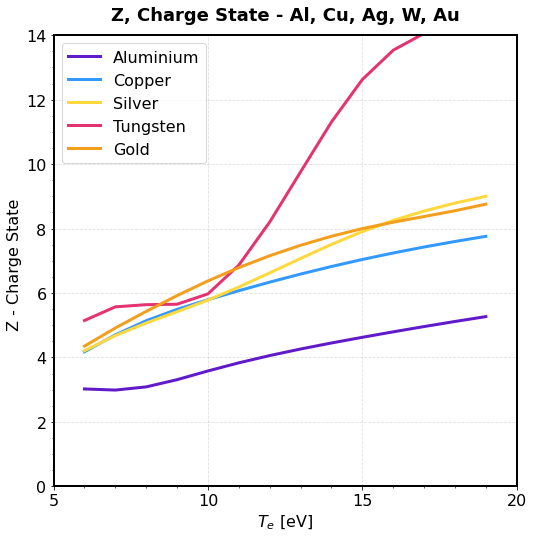

In [66]:
# DEFINE PLASMA
# -------------------------------------------------------------------------------------
Te      =    np.arange(6,20)       # electron temperature eV

al_flow = {'A':27, 'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
cu_flow  = {'A':64,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
ag_flow  = {'A':108,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
w_flow  = {'A':183,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
au_flow  = {'A':197,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}


al  =   plasma(**al_flow)
cu  =   plasma(**cu_flow)
ag   =   plasma(**ag_flow)
w   =   plasma(**w_flow)
au   =   plasma(**au_flow)


# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
ax0 = fig.add_subplot()

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)

ax0.plot(Te, al.Z, lw = '3', color = '#611ACA',label='Aluminium')
ax0.plot(Te, cu.Z,  lw = '3', color = '#3299FF',label='Copper')
ax0.plot(Te, ag.Z,  lw = '3', color = '#FFD83B',label='Silver')
ax0.plot(Te, w.Z,  lw = '3', color = '#E53271',label='Tungsten')
ax0.plot(Te, au.Z,  lw = '3', color = '#F39E1D',label='Gold')


ax0.set_title('Z, Charge State - Al, Cu, Ag, W, Au', fontsize = 18,  weight = 'bold', pad = "15")

ax0.set_ylim([0,14])
ax0.set_xlim([5,20])
ax0.set_xticks(np.arange(5,20.1,5))
ax0.set_yticks(np.arange(0,14.1,2))

# Plot Properties
ax0.tick_params(labelsize=16)
ax0.grid(True, linestyle='--', alpha = 0.4)

ax0.set_xlabel(r'$T_e$ [eV]', fontsize=16)
ax0.set_ylabel(r'Z - Charge State ', fontsize=16)
ax0.minorticks_on()
ax0.legend(loc = 'best', fontsize = 16)

# plt.savefig('ChargeStateExperimentalValuesSameMassDensity.png', dpi=330)


# $n_e$, Electron Density - Electron Temperature Relation given a fixed mass density, $\rho_0$ = 6.1 x $10^{-5} gr/cm^3$

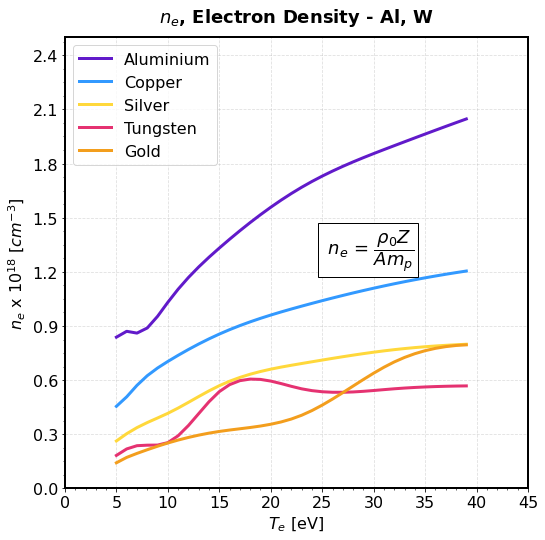

In [67]:
# DEFINE PLASMA
# -------------------------------------------------------------------------------------
Te      =    np.arange(5,40)       # electron temperature eV

al_flow = {'A':27, 'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
cu_flow  = {'A':64,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
ag_flow  = {'A':108,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
w_flow  = {'A':183,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}
au_flow  = {'A':197,'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':5e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'FLY', 'B': 5}

al  =   plasma(**al_flow)
w   =   plasma(**w_flow)
cu  =   plasma(**cu_flow)
ag   =   plasma(**ag_flow)
au   =   plasma(**au_flow)

# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
ax0 = fig.add_subplot()

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)

ax0.plot(Te, al.ne*1e-18, lw = '3', color = '#611ACA',label='Aluminium')
ax0.plot(Te, cu.ne*1e-18,  lw = '3', color = '#3299FF',label='Copper')
ax0.plot(Te, ag.ne*1e-18,  lw = '3', color = '#FFD83B',label='Silver')
ax0.plot(Te, w.ne*1e-18,  lw = '3', color = '#E53271',label='Tungsten')
ax0.plot(Te, au.ne*1e-18,  lw = '3', color = '#F39E1D',label='Gold')


ax0.set_title('$n_e$, Electron Density - Al, W', fontsize = 18,  weight = 'bold', pad = "15")

ax0.set_ylim([0,2.5])
ax0.set_xlim([0,45])
ax0.set_xticks(np.arange(0,46,5))
ax0.set_yticks(np.arange(0,2.51,0.3))


ax0.text(25, 1.3,r' $n_e$ = $\dfrac{\rho_0 Z}{A m_p}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# Plot Properties
ax0.tick_params(labelsize=16)
ax0.grid(True, linestyle='--', alpha = 0.4)

ax0.set_xlabel(r'$T_e$ [eV]', fontsize=16)
ax0.set_ylabel(r'$n_e$ x $10^{18}$ [$cm^{-3}$]', fontsize=16)
ax0.minorticks_on()
ax0.legend(loc = 'best', fontsize = 16)

# plt.savefig('ElectronDensity_1.3e-5_AL_W.png', dpi=330)

# Analisys: Ion Plasma Frequency, Ion Inertial Length, Ion Larmor Radius

Text(0, 0.5, 'Ion Larmor Radius x $10^{-2}$ - [cm]')

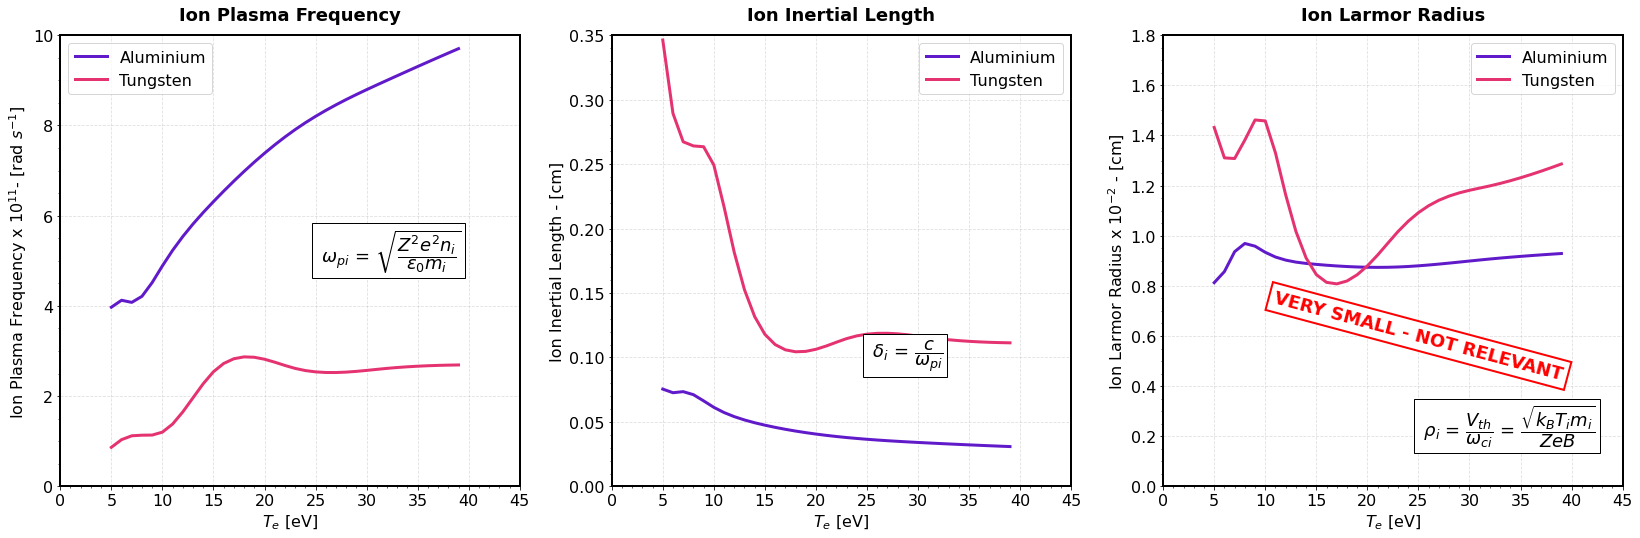

In [56]:
# PRETTY PLOT
# --------------------------------------------------------------------------------------
fig = plt.figure(figsize=(28,8.3))
gs  = fig.add_gridspec(ncols=3, nrows=1,hspace=0,wspace=0.2)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
    ax[2].spines[axis].set_linewidth(2)

ax[0].plot(Te, al.om_pi   * 1e-11, lw = '3', color = '#611ACA',label='Aluminium')
ax[1].plot(Te, al.delta_i,   lw = '3', color = '#611ACA',label='Aluminium')
ax[2].plot(Te, al.rho_i*1e2,   lw = '3', color = '#611ACA',label='Aluminium')

ax[0].plot(Te, w.om_pi    * 1e-11, lw = '3', color = '#E53271',label='Tungsten')
ax[1].plot(Te, w.delta_i,   lw = '3', color = '#E53271',label='Tungsten')
ax[2].plot(Te, w.rho_i*1e2,   lw = '3', color = '#E53271',label='Tungsten')


ax[0].set_title('Ion Plasma Frequency', fontsize = 18,  weight = 'bold', pad = "15")
ax[1].set_title('Ion Inertial Length', fontsize = 18,  weight = 'bold', pad = "15")
ax[2].set_title('Ion Larmor Radius', fontsize = 18,  weight = 'bold', pad = "15")

for axis in ax:
    axis.set_xlim([0,45])
    axis.set_xticks(np.arange(0,46,5))
    axis.tick_params(labelsize=16)
    axis.grid(True, linestyle='--', alpha = 0.4)
    axis.set_xlabel(r'$T_e$ [eV]', fontsize=16)
    axis.minorticks_on()
    axis.legend(loc = 'best', fontsize = 16)


ax[0].set_ylim([0,10])
ax[0].set_yticks(np.arange(0,10.1,2))

ax[1].set_ylim([0,0.35])
ax[1].set_yticks(np.arange(0,0.351,0.05))

ax[2].set_ylim([0,1.8])
ax[2].set_yticks(np.arange(0,1.81,0.2))


ionplasmafreq_eq    =    r' $\omega_{pi}$ = $\sqrt{\dfrac{Z^2 e^2 n_i}{\epsilon_0 m_i}}$'
ax[0].text(25, 5, ionplasmafreq_eq, fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ioninertialleg_eq   =    r' $\delta_{i}$ = $\dfrac{c}{\omega_{pi}}$'
ax[1].text(25, 0.1, ioninertialleg_eq, fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ionlarmorrad_eq   =    r' $\rho_{i}$ = $\dfrac{V_{th}}{\omega_{ci}}$ = $\dfrac{\sqrt{k_B T_i m_i}}{ZeB}$'
ax[2].text(25, 0.2, ionlarmorrad_eq, fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

t = ax[2].text(
    25, 0.6, "VERY SMALL - NOT RELEVANT", color = "red", weight="bold", ha="center", va="center", rotation=-15, size=18,
    bbox=dict(boxstyle="Square,pad=0.3", fc="white", ec="red", lw=2))


ax[0].set_ylabel(r'Ion Plasma Frequency x $10^{11}$- [rad $s^{-1}$] ', fontsize=16)
ax[1].set_ylabel(r'Ion Inertial Length - [cm]', fontsize=16)
ax[2].set_ylabel(r'Ion Larmor Radius x $10^{-2}$ - [cm]', fontsize=16)

# plt.savefig('IonInertialLength_1.3e-5_AL_W.png', dpi=330)


# Reynolds Numbers: $Re$, $Re_m$

Text(0, 0.5, '$Re_m$')

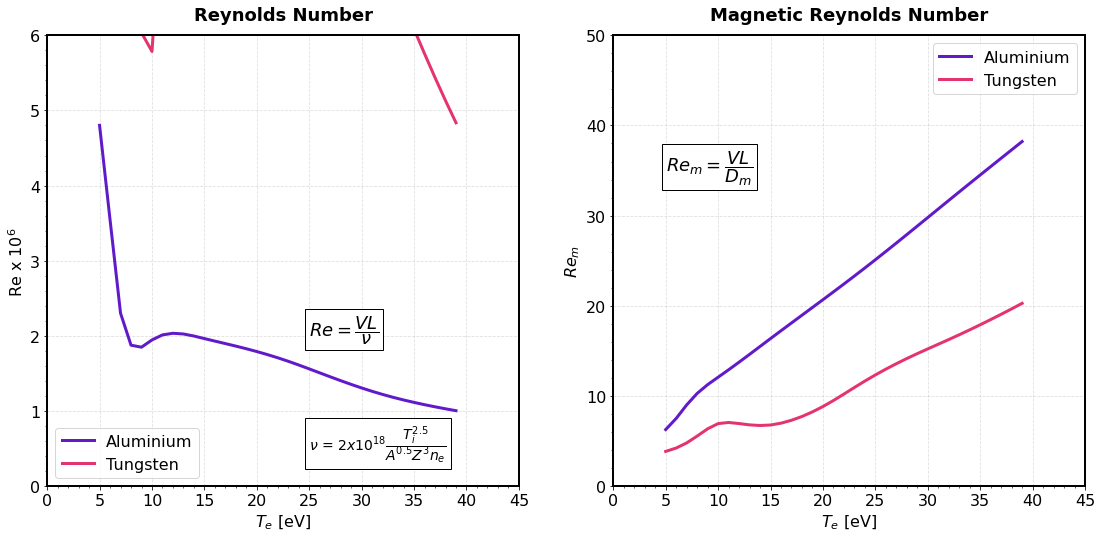

In [57]:
# PRETTY PLOT
# --------------------------------------------------------------------------------------
fig = plt.figure(figsize=(18.6,8.3))
gs  = fig.add_gridspec(ncols=2, nrows=1,hspace=0,wspace=0.2)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

ax[0].plot(Te, al.Re * 1e-6, lw = '3', color = '#611ACA',label='Aluminium')
ax[1].plot(Te, al.Re_m, lw = '3', color = '#611ACA',label='Aluminium')

ax[0].plot(Te, w.Re * 1e-6, lw = '3', color = '#E53271',label='Tungsten')
ax[1].plot(Te, w.Re_m, lw = '3', color = '#E53271',label='Tungsten')

ax[0].set_title('Reynolds Number', fontsize = 18,  weight = 'bold', pad = "15")
ax[1].set_title('Magnetic Reynolds Number', fontsize = 18,  weight = 'bold', pad = "15")

for axis in ax:
    axis.set_xlim([0,45])
    axis.set_xticks(np.arange(0,46,5))
    axis.tick_params(labelsize=16)
    axis.grid(True, linestyle='--', alpha = 0.4)
    axis.set_xlabel(r'$T_e$ [eV]', fontsize=16)
    axis.minorticks_on()
    axis.legend(loc = 'best', fontsize = 16)

ax[0].set_ylim([0,6])
ax[0].set_yticks(np.arange(0,6.1,1))
ax[1].set_ylim([0,50])
ax[1].set_yticks(np.arange(0,51,10))

# (2e18*self.Ti**2.5)/(self.A**0.5*self.Z**3*self.ne) 
ax[0].text(25, 0.5, r'$\nu$ = $2x10^{18}\dfrac{T_i^{2.5}}{A^{0.5}Z^{3}n_e}$', fontsize = 14, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax[0].text(25, 2, r'$Re = \dfrac{VL}{\nu}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ax[1].text(5, 35, r'$Re_m = \dfrac{VL}{D_m}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ax[0].set_ylabel(r'Re x $10^{6}$', fontsize=16)
ax[1].set_ylabel(r'$Re_m$', fontsize=16)

# plt.savefig('Reynolds_1.3e-5_AL_W.png', dpi=330)


# Analysis: Magnetic Diffusion - Spatial and Time Characteristic Scales

Text(0, 0.5, 'Diffusion scale [cm]')

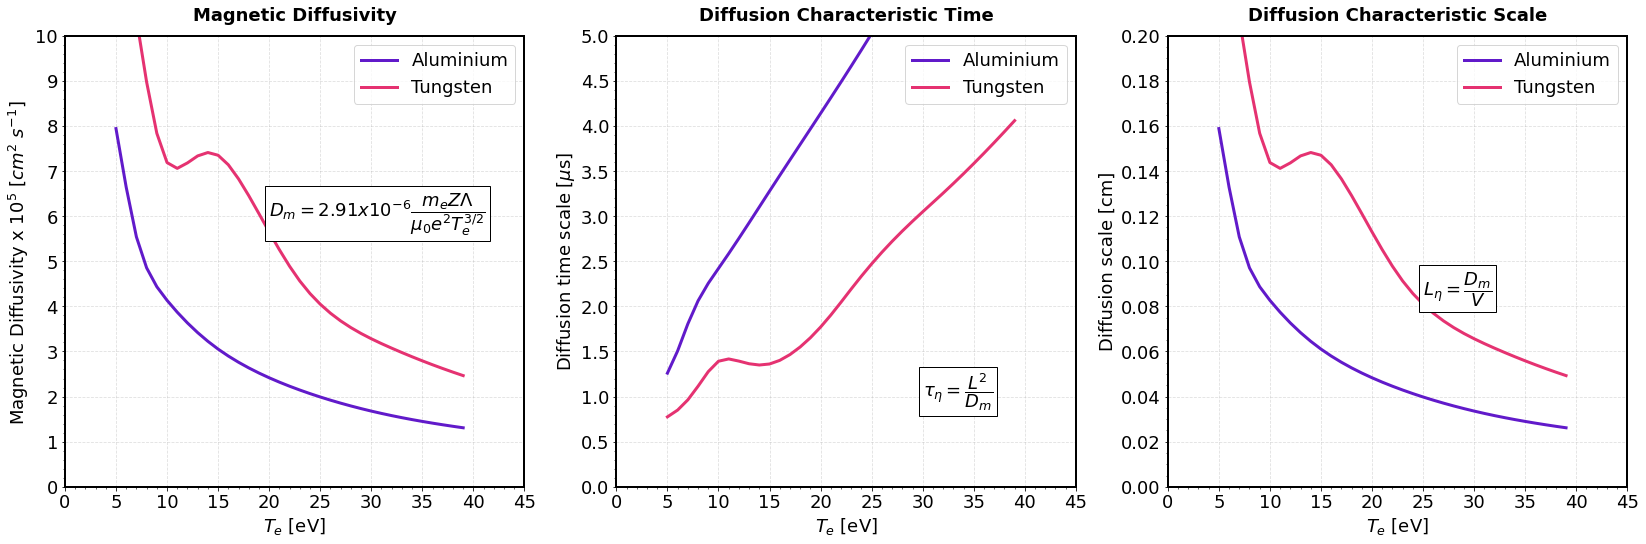

In [58]:
# PRETTY PLOT
# --------------------------------------------------------------------------------------
fig = plt.figure(figsize=(28,8.3))
gs  = fig.add_gridspec(ncols=3, nrows=1,hspace=0,wspace=0.2)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
    ax[2].spines[axis].set_linewidth(2)

ax[0].plot(Te, al.Dm*1e-5, lw = '3', color = '#611ACA',label='Aluminium')
ax[1].plot(Te, 1/(al.Dm)*1e6, lw = '3', color = '#611ACA',label='Aluminium') # assumed L = 1cm
ax[2].plot(Te, al.Leta, lw = '3', color = '#611ACA',label='Aluminium')


ax[0].plot(Te, w.Dm*1e-5, lw = '3', color = '#E53271',label='Tungsten')
ax[1].plot(Te, 1/(w.Dm)*1e6, lw = '3', color = '#E53271',label='Tungsten')  #assumed L = 1cm
ax[2].plot(Te, w.Leta, lw = '3', color = '#E53271',label='Tungsten')


ax[0].set_title('Magnetic Diffusivity', fontsize = 18,  weight = 'bold', pad = "15")
ax[1].set_title('Diffusion Characteristic Time', fontsize = 18,  weight = 'bold', pad = "15")
ax[2].set_title('Diffusion Characteristic Scale', fontsize = 18,  weight = 'bold', pad = "15")

ax[0].text(20, 6, r'$D_m = 2.91x10^{-6}\dfrac{m_e Z \Lambda}{\mu_0 e^2 T_e^{3/2}}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax[1].text(30, 1, r'$ \tau_{\eta} = \dfrac{L^2}{D_m}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax[2].text(25, 0.085, r'$ L_{\eta} = \dfrac{D_m}{V}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ax[0].set_ylim([0,10])
ax[0].set_yticks(np.arange(0,10.1,1))

ax[1].set_ylim([0,5])
ax[1].set_yticks(np.arange(0,5.1,0.5))

ax[2].set_ylim([0,0.2])
ax[2].set_yticks(np.arange(0,0.21,0.02))

for axis in ax:
    axis.set_xlim([0,45])
    axis.set_xticks(np.arange(0,46,5))
    axis.tick_params(labelsize=18)
    axis.grid(True, linestyle='--', alpha = 0.4)
    axis.set_xlabel(r'$T_e$ [eV]', fontsize=18)
    axis.minorticks_on()
    axis.legend(loc = 'best', fontsize = 18)

ax[0].set_ylabel(r'Magnetic Diffusivity x $10^{5}$ [$cm^2$ $s^{-1}$] ', fontsize=18)
ax[1].set_ylabel(r'Diffusion time scale [$\mu$s]', fontsize=18)
ax[2].set_ylabel(r'Diffusion scale [cm]', fontsize=18)

# plt.savefig('DiffusionTimeSpaceScale_1.3e-5_AL_W.png', dpi=330)


In [59]:
# Resistivity ETA

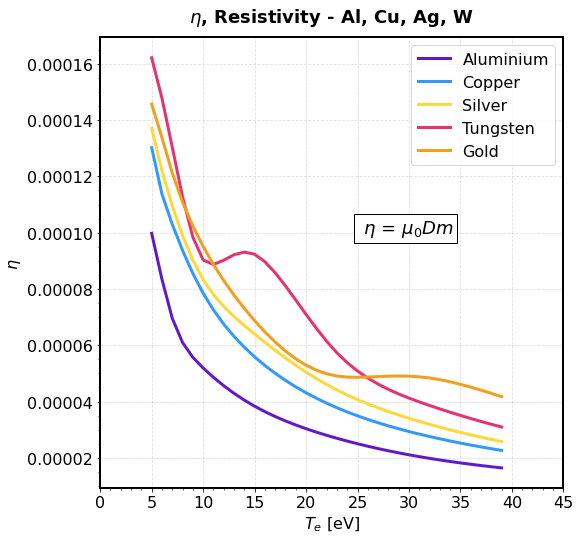

In [68]:
# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
ax0 = fig.add_subplot()

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)

ax0.plot(Te, al.eta, lw = '3', color = '#611ACA',label='Aluminium')
ax0.plot(Te, cu.eta,  lw = '3', color = '#3299FF',label='Copper')
ax0.plot(Te, ag.eta,  lw = '3', color = '#FFD83B',label='Silver')
ax0.plot(Te, w.eta,  lw = '3', color = '#E53271',label='Tungsten')
ax0.plot(Te, au.eta,  lw = '3', color = '#F39E1D',label='Gold')


ax0.set_title('$\eta$, Resistivity - Al, Cu, Ag, W', fontsize = 18,  weight = 'bold', pad = "15")

# ax0.set_ylim([0,2.5])
ax0.set_xlim([0,45])
ax0.set_xticks(np.arange(0,46,5))
# ax0.set_yticks(np.arange(0,2.51,0.3))


ax0.text(25, 0.00010,r' $\eta$ = $\mu_0 Dm$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# Plot Properties
ax0.tick_params(labelsize=16)
ax0.grid(True, linestyle='--', alpha = 0.4)

ax0.set_xlabel(r'$T_e$ [eV]', fontsize=16)
ax0.set_ylabel(r'$\eta$', fontsize=16)
ax0.minorticks_on()
ax0.legend(loc = 'best', fontsize = 16)

# plt.savefig('ElectronDensity_1.3e-5_AL_W.png', dpi=330)

# Growth Rate MRTI - General Model

## <h2> <center> $\gamma^2 = gk - {2(k B_0)^2}/{\mu_0 \rho}$ </center> </h2>

In [61]:
def growth_rate(plasma,wl):

    a     =   plasma.a * 1e-2                               # Acceleration          [cm/s^2]  --> [m/s^2]
    B     =   plasma.B                                      # Magnetic field        [Tesla]
    rho   =   plasma.density * 1e3                          # Density               [gr/cm^3] --> [kg/m^3]

    kc      =   (a * rho * cons.mu_0) / (2 * B**2)          # Critical Wave vector  [m^-1]
    wl_c    =   2*np.pi/kc                                  # lambda critical       [m]

    print('Acceleration, a:        ' + np.format_float_scientific(a, precision = 1, exp_digits=2)             +    '  m/s^2')
    print('Density:                ' + np.format_float_scientific(rho, precision = 1, exp_digits=2)           +    '  kg/cm^3')
    print('Critical wavevector k : ' + np.format_float_scientific(kc*1e2, precision = 1, exp_digits=2)        +    '  cm^-1')
    print('Critical wavenumber wc: ' + np.format_float_scientific(wl_c*1e2, precision = 1, exp_digits=2)        +    '  cm')

    wl = wl * 1e-2                                          # [cm]          -->     [m]
    k = 2*np.pi / wl                                        # [cm^-1]       -->     [m^-1]
    
    gr    =   a * k - 2*(k * B)**2 / (cons.mu_0 * rho)
    gr    =   np.where(gr<0, 0, gr)
        
    return gr, wl_c


Aluminium Acceleration, a:  9.e+11  cm/s^2
Aluminium Charge State, Z:  4.0e+00
Aluminium Density:          1.3e-05  g/cm^3
Aluminium ne:               1.2e+18  cm^-3
Aluminium Te:               1.5e+01  eV


Tungsten Acceleration, a:   4.9e+12  cm/s^2
Tungsten Charge State, Z:   5.0e+00
Tungsten Density:           1.3e-05  g/cm^3
Tungsten ne:                2.1e+17  cm^-3
Tungsten Te:                1.e+01  eV


Acceleration, a:        9.e+09  m/s^2
Density:                1.3e-02  kg/cm^3
Critical wavevector k : 2.9e+02  cm^-1
Critical wavenumber wc: 2.1e+02  cm
Acceleration, a:        4.9e+10  m/s^2
Density:                1.3e-02  kg/cm^3
Critical wavevector k : 1.6e+03  cm^-1
Critical wavenumber wc: 3.9e+01  cm


<ipython-input-61-9aea5534009e>:16: RuntimeWarning: divide by zero encountered in true_divide
  k = 2*np.pi / wl                                        # [cm^-1]       -->     [m^-1]
<ipython-input-61-9aea5534009e>:18: RuntimeWarning: invalid value encountered in subtract
  gr    =   a * k - 2*(k * B)**2 / (cons.mu_0 * rho)
<ipython-input-62-983e5c433c9a>:47: RuntimeWarning: divide by zero encountered in true_divide
  ax0.plot(wl, 1e6/(gr_al)**0.5, lw = '3', color = 'black', label='')
<ipython-input-62-983e5c433c9a>:51: RuntimeWarning: divide by zero encountered in true_divide
  ax0.plot(wl, 1e6/(gr_w)**0.5, lw = '3', color = 'black', label='')


Text(0.5, 1.0, 'MRT - Undular Mode, k || $B_0$ ')

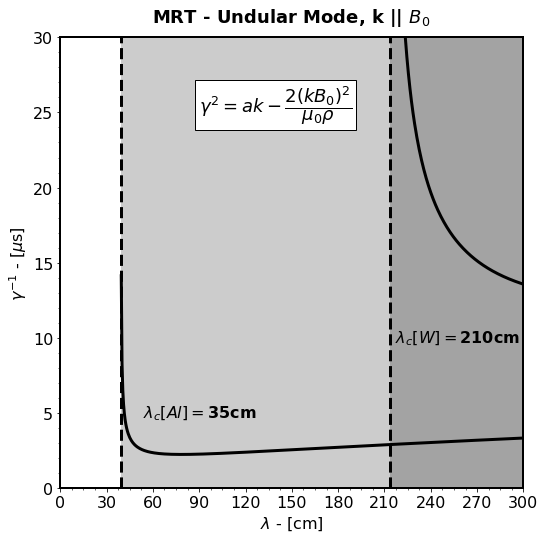

In [62]:
# DEFINE PLASMA
# -------------------------------------------------------------------------------------
# Te      =    np.arange(10,60)       # electron temperature eV

Te = 15

al_flow         =    {'A':27, 'density': 1.3e-5, 'Te': Te , 'Ti': Te, 'V':3e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
w_flow          =    {'A':183,'density': 1.3e-5, 'Te': 10 , 'Ti': 10, 'V':7e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

al  =   plasma(**al_flow)
w   =   plasma(**w_flow)

# CALCULATE THE GROWTH RATE WITH B FIELD - UNDULAR MODE
# -------------------------------------------------------------------------------------

wl = np.arange(0,300,0.5)                    # [cm]

print('Aluminium Acceleration, a:  ' + np.format_float_scientific(al.a, precision = 1, exp_digits=2)        +    '  cm/s^2')
print('Aluminium Charge State, Z:  ' + np.format_float_scientific(al.Z, precision = 1, exp_digits=2))
print('Aluminium Density:          ' + np.format_float_scientific(al.density, precision = 1, exp_digits=2)  +    '  g/cm^3')
print('Aluminium ne:               ' + np.format_float_scientific(al.ne, precision = 1, exp_digits=2)       +    '  cm^-3')
print('Aluminium Te:               ' + np.format_float_scientific(al.Te, precision = 1, exp_digits=2)       +    '  eV')

print('\n')

print('Tungsten Acceleration, a:   ' + np.format_float_scientific(w.a, precision = 1, exp_digits=2)         +    '  cm/s^2')
print('Tungsten Charge State, Z:   ' + np.format_float_scientific(w.Z, precision = 1, exp_digits=2))
print('Tungsten Density:           ' + np.format_float_scientific(w.density, precision = 1, exp_digits=2)   +    '  g/cm^3')
print('Tungsten ne:                ' + np.format_float_scientific(w.ne, precision = 1, exp_digits=2)        +    '  cm^-3')
print('Tungsten Te:                ' + np.format_float_scientific(w.Te, precision = 1, exp_digits=2)        +    '  eV')

print('\n')

gr_al, al_wl_c = growth_rate(al,wl)
gr_w, w_wl_c  = growth_rate(w,wl)


# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
ax0 = fig.add_subplot()

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)

ax0.plot(wl, 1e6/(gr_al)**0.5, lw = '3', color = 'black', label='')
ax0.axvline(x=al_wl_c*1e2, ls = '--', lw = '3', color = 'black',label='Aluminium' )
ax0.axvspan(al_wl_c*1e2, 300, facecolor='black', alpha=0.2)

ax0.plot(wl, 1e6/(gr_w)**0.5, lw = '3', color = 'black', label='')
ax0.axvline(x=w_wl_c*1e2, ls = '--', lw = '3', color = 'black',label='Tungsten' )
ax0.axvspan(w_wl_c*1e2, 300, facecolor='black', alpha=0.2)

ax0.set_ylim([0,30])
ax0.set_yticks(np.arange(0,30.1,5))

ax0.set_xlim([0,300])
ax0.set_xticks(np.arange(0,300.1,30))


# Plot Properties
ax0.tick_params(labelsize=16)
# ax0.grid(True, linestyle='--', alpha = 0.4)

ax0.set_xlabel(r'$\lambda$ - [cm]', fontsize=16)
ax0.set_ylabel(r'$\gamma^{-1}$ - [$\mu$s]', fontsize=16)
ax0.minorticks_on()
# ax0.legend(loc = 'best', fontsize = 16)

t = ax0.text(
    90, 5, "$\lambda_c [Al] = $"+str(35)+'cm', color = "black", weight="bold", ha="center", va="center", size=16)

t = ax0.text(
    257, 10, "$\lambda_c [W] = $"+str(210)+'cm', color = "black", weight="bold", ha="center", va="center", size=16)

ax0.text(90, 25, r'$\gamma^2 = ak - \dfrac{2(kB_0)^2}{\mu_0\rho}$', fontsize = 18, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax0.set_title('MRT - Undular Mode, k || $B_0$ ', fontsize = 18,  weight = 'bold', pad = "15")

# plt.savefig('MRTUndularMode_1.3e-5_AL_W.png', dpi=330)

# Growth Rate with & without diffusivity damping

## <h2> <center> $\gamma = (gk)^{1/2} - D_mk^2$ </center> </h2>

In [63]:
def growth_rate_damped(plasma, wl):
    a     =   plasma.a                                      # Acceleration          [cm/s^2]
    Dm    =   plasma.Dm                                     # Magnetic Diffusivity  [cm^2 s]
    Atw   =   plasma.Atw                                    # Atwood Number 
    
    kc      =   (a / Dm**2 )**(1/3)                         # Critical Wave vector  [cm^-1]
    wl_c    =   2*np.pi/kc                                  # lambda critical       [cm]

    if (plasma.A == 27):
        print('Aluminium')
    else:
        print('Tungsten')
    print('Te: ', plasma.Te)
    print('Acceleration, a:           ' + np.format_float_scientific(a, precision = 1, exp_digits=2)         +    '  cm/s^2')
    print('Magnetic Diffusivity, Dm:  ' + np.format_float_scientific(Dm, precision = 1, exp_digits=2)        +    '  cm^2/s')
    print('Critical wavevector kc:    ' + np.format_float_scientific(kc, precision = 1, exp_digits=2)        +    '  cm^-1')
    print('Critical wavenumber wc:    ' + np.format_float_scientific(wl_c, precision = 1, exp_digits=2)      +    '  cm')
    print('-----------------------------------------------')

    k           =   2*np.pi / wl                            # K-vector [cm^-1]
    
    gr          =   (Atw * a * k)**0.5                      # Inertial Component - NO Damping
    gr_damp     =    gr - Dm*k**2                           # Inertial Component + Damping Component

    # gr_damp[gr_damp > 0]
    gr_damp     =   np.where(gr_damp<0, 0, gr_damp)

    return gr, gr_damp, wl_c

Aluminium
Te:  10
Acceleration, a:           9.e+11  cm/s^2
Magnetic Diffusivity, Dm:  3.7e+05  cm^2/s
Critical wavevector kc:    1.9e+00  cm^-1
Critical wavenumber wc:    3.4e+00  cm
-----------------------------------------------
Tungsten
Te:  10
Acceleration, a:           4.9e+12  cm/s^2
Magnetic Diffusivity, Dm:  6.4e+05  cm^2/s
Critical wavevector kc:    2.3e+00  cm^-1
Critical wavenumber wc:    2.7e+00  cm
-----------------------------------------------
Aluminium
Te:  15
Acceleration, a:           9.e+11  cm/s^2
Magnetic Diffusivity, Dm:  2.8e+05  cm^2/s
Critical wavevector kc:    2.3e+00  cm^-1
Critical wavenumber wc:    2.8e+00  cm
-----------------------------------------------
Tungsten
Te:  15
Acceleration, a:           4.9e+12  cm/s^2
Magnetic Diffusivity, Dm:  5.3e+05  cm^2/s
Critical wavevector kc:    2.6e+00  cm^-1
Critical wavenumber wc:    2.4e+00  cm
-----------------------------------------------
Aluminium
Te:  20
Acceleration, a:           9.e+11  cm/s^2
Magnetic Dif

<ipython-input-63-4f5c0676f58d>:20: RuntimeWarning: divide by zero encountered in true_divide
  k           =   2*np.pi / wl                            # K-vector [cm^-1]
<ipython-input-63-4f5c0676f58d>:23: RuntimeWarning: invalid value encountered in subtract
  gr_damp     =    gr - Dm*k**2                           # Inertial Component + Damping Component
<ipython-input-64-fc6a2255aebd>:29: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(wl*10, 1e6/gr_dam_al,  lw = '4', color=shade_al[i])
<ipython-input-64-fc6a2255aebd>:34: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(wl*10, 1e6/gr_dam_w,  lw = '4', color=shade_w[i])
<ipython-input-63-4f5c0676f58d>:20: RuntimeWarning: divide by zero encountered in true_divide
  k           =   2*np.pi / wl                            # K-vector [cm^-1]
<ipython-input-63-4f5c0676f58d>:23: RuntimeWarning: invalid value encountered in subtract
  gr_damp     =    gr - Dm*k**2                           # Ine

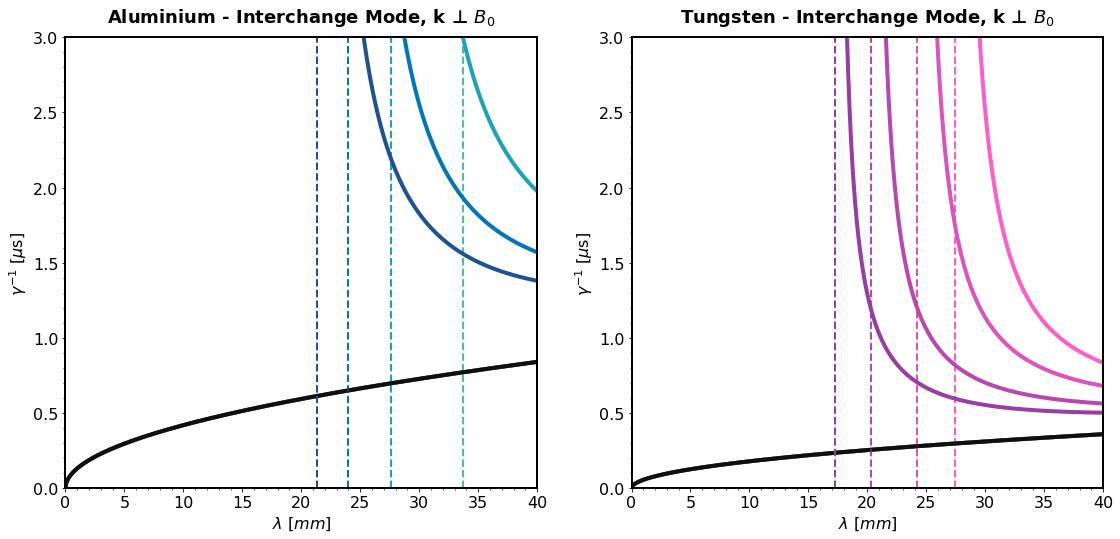

In [64]:
wl = np.arange(0,4,0.001)                    # [cm]

# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(18.6,8.3))
gs  = fig.add_gridspec(ncols=2, nrows=1,hspace=0,wspace=0.2)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

shade_al = ['#50BFA1','#1DA3B8','#0077BC','#1D5391','#233C75']
shade_w = ['#FF5CCC','#DC52BF','#B947B1','#973DA4','#512889']

for i,temp in enumerate([10,15,20,25]):
    al_flow         =    {'A':27, 'density': 1.3e-5, 'Te': temp , 'Ti': temp, 'V':3e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
    w_flow          =    {'A':183,'density': 1.3e-5, 'Te': temp , 'Ti': temp, 'V':7e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

    al              =   plasma(**al_flow)
    w               =   plasma(**w_flow)

    # CALL GROWTH RATE FUNCTION
    gr_no_dam_al, gr_dam_al, al_wl_c   =    growth_rate_damped(al,wl)
    gr_no_dam_w,  gr_dam_w,  w_wl_c    =    growth_rate_damped(w,wl)

    ax[0].plot(wl*10, 1e6/gr_no_dam_al, lw = '4', linestyle = '-', color='black', alpha =0.5)
    ax[0].plot(wl*10, 1e6/gr_dam_al,  lw = '4', color=shade_al[i])
    ax[0].axvline(x=al_wl_c*10, ls = '--', lw = '2', color = shade_al[i])


    ax[1].plot(wl*10, 1e6/gr_no_dam_w, lw = '4', linestyle = '-', color='black', alpha =0.5)
    ax[1].plot(wl*10, 1e6/gr_dam_w,  lw = '4', color=shade_w[i])
    ax[1].axvline(x=w_wl_c*10, ls = '--', lw = '2', color = shade_w[i])


ax[0].set_title('Aluminium - Interchange Mode, k ⊥ $B_0$', fontsize = 18,  weight = 'bold', pad = "15")
ax[1].set_title('Tungsten - Interchange Mode, k ⊥ $B_0$', fontsize = 18,  weight = 'bold', pad = "15")

for axis in ax:
    axis.set_xlim([0,40])
    axis.set_xticks(np.arange(0,40.1,5))
    axis.set_ylim([0,3])
    axis.set_yticks(np.arange(0,3.1,0.5))
    axis.tick_params(labelsize=16)
    axis.set_xlabel(r'$\lambda$ [$mm$]', fontsize=16)
    axis.set_ylabel(r'$\gamma^{-1}$ [$\mu$s]', fontsize=16)
    axis.minorticks_on()
    # axis.legend(['Without $D_m$','With $D_m$'],loc = 'upper right', frameon=False, fontsize = 16)

# plt.savefig('gamma_damping_1.3e-5_AL_W.png', dpi=330) 

# Growth Rate without damping

## <h2> <center> $\gamma = (gk)^{1/2} $</center> </h2>

Aluminium
Te:  10
Acceleration, a:           9.e+11  cm/s^2
Magnetic Diffusivity, Dm:  3.7e+05  cm^2/s
Critical wavevector kc:    1.9e+00  cm^-1
Critical wavenumber wc:    3.4e+00  cm
-----------------------------------------------
Tungsten
Te:  10
Acceleration, a:           4.9e+12  cm/s^2
Magnetic Diffusivity, Dm:  6.4e+05  cm^2/s
Critical wavevector kc:    2.3e+00  cm^-1
Critical wavenumber wc:    2.7e+00  cm
-----------------------------------------------
Aluminium
Te:  15
Acceleration, a:           9.e+11  cm/s^2
Magnetic Diffusivity, Dm:  2.8e+05  cm^2/s
Critical wavevector kc:    2.3e+00  cm^-1
Critical wavenumber wc:    2.8e+00  cm
-----------------------------------------------
Tungsten
Te:  15
Acceleration, a:           4.9e+12  cm/s^2
Magnetic Diffusivity, Dm:  5.3e+05  cm^2/s
Critical wavevector kc:    2.6e+00  cm^-1
Critical wavenumber wc:    2.4e+00  cm
-----------------------------------------------
Aluminium
Te:  20
Acceleration, a:           9.e+11  cm/s^2
Magnetic Dif

<ipython-input-63-4f5c0676f58d>:20: RuntimeWarning: divide by zero encountered in true_divide
  k           =   2*np.pi / wl                            # K-vector [cm^-1]
<ipython-input-63-4f5c0676f58d>:23: RuntimeWarning: invalid value encountered in subtract
  gr_damp     =    gr - Dm*k**2                           # Inertial Component + Damping Component
<ipython-input-63-4f5c0676f58d>:20: RuntimeWarning: divide by zero encountered in true_divide
  k           =   2*np.pi / wl                            # K-vector [cm^-1]
<ipython-input-63-4f5c0676f58d>:23: RuntimeWarning: invalid value encountered in subtract
  gr_damp     =    gr - Dm*k**2                           # Inertial Component + Damping Component
<ipython-input-63-4f5c0676f58d>:20: RuntimeWarning: divide by zero encountered in true_divide
  k           =   2*np.pi / wl                            # K-vector [cm^-1]
<ipython-input-63-4f5c0676f58d>:23: RuntimeWarning: invalid value encountered in subtract
  gr_damp     =    

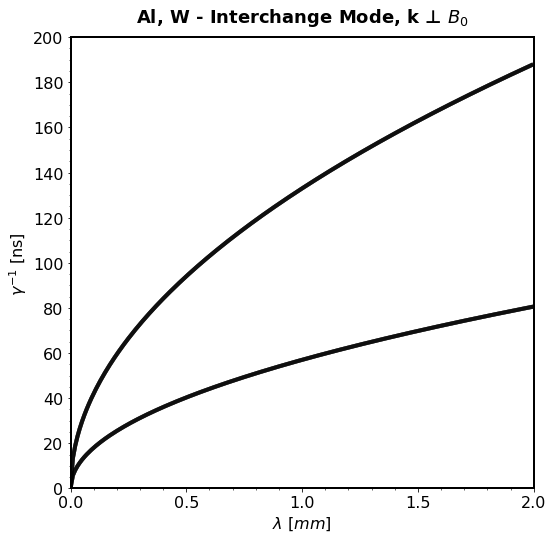

In [65]:
wl = np.arange(0,0.2,0.001)                    # [cm]

# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
gs  = fig.add_gridspec(ncols=1, nrows=1,hspace=0,wspace=0.2)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for i,temp in enumerate([10,15,20,25]):
    al_flow         =    {'A':27, 'density': 1.3e-5, 'Te': temp , 'Ti': temp, 'V':3e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
    w_flow          =    {'A':183,'density': 1.3e-5, 'Te': temp , 'Ti': temp, 'V':7e5,  'L':0.1, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

    al              =   plasma(**al_flow)
    w               =   plasma(**w_flow)

    # CALL GROWTH RATE FUNCTION
    gr_no_dam_al, gr_dam_al, al_wl_c   =    growth_rate_damped(al,wl)
    gr_no_dam_w,  gr_dam_w,  w_wl_c    =    growth_rate_damped(w,wl)

    ax.plot(wl*10, 1e9/gr_no_dam_al, lw = '4', linestyle = '-', color='black', alpha =0.5)
    ax.plot(wl*10, 1e9/gr_no_dam_w, lw = '4', linestyle = '-', color='black', alpha =0.5)


ax.set_title('Al, W - Interchange Mode, k ⊥ $B_0$', fontsize = 18,  weight = 'bold', pad = "15")

ax.set_xlim([0,2])
ax.set_xticks(np.arange(0,2.1,0.5))
ax.set_ylim([0,200])
ax.set_yticks(np.arange(0,200.1,20))
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\lambda$ [$mm$]', fontsize=16)
ax.set_ylabel(r'$\gamma^{-1}$ [ns]', fontsize=16)
ax.minorticks_on()
    # axis.legend(['Without $D_m$','With $D_m$'],loc = 'upper right', frameon=False, fontsize = 16)

# plt.savefig('gamma_NOdamping_1.3e-5_AL_W.png', dpi=330) 